# Optimized Support Vector Machine (Kernel Approximation)

In this notebook, we implement an **Optimized SVM** model using **Kernel Approximation**.

**Problem**: The Forest Cover dataset is highly non-linear, so Linear SVMs underperform.
**Scalability Issue**: Standard `SVC(kernel='rbf')` scales as $O(N^3)$, which is too slow for 580,000 samples.
**Solution**: We use **`Nystroem`** (Kernel Approximation) combined with **`SGDClassifier`**. This approximates the RBF kernel using a subset of data points, which is often more accurate than random Fourier features.

**Improvements**:
1.  **Nystroem**: Non-linear mapping using data subsets.
2.  **PowerTransformer**: Normalizing skewed features.
3.  **Feature Engineering**: Adding Euclidean Distance to Hydrology.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load Data

In [11]:
# Load Datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()

X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv').values.ravel()

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').values.ravel()

# Combine Train and Val for Fixed Validation Split
X_dev = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_dev = np.concatenate([y_train, y_val], axis=0)

# Create PredefinedSplit
test_fold = np.concatenate([
    np.full(len(X_train), -1), # Train
    np.full(len(X_val), 0)     # Validation
])
ps = PredefinedSplit(test_fold)

print(f"Development Set Shape: {X_dev.shape}")

Development Set Shape: (464809, 54)


## 2. Feature Engineering

We apply the same feature engineering that improved the Logistic Regression model.


In [12]:
def add_features(df):
    df = df.copy()
    # Euclidean distance to Hydrology
    df['Euclidean_Distance_To_Hydrology'] = np.sqrt(
        df['Horizontal_Distance_To_Hydrology']**2 + 
        df['Vertical_Distance_To_Hydrology']**2
    )
    return df

# Apply to Dev and Test sets
X_dev_fe = add_features(X_dev)
X_test_fe = add_features(X_test)

print("Added feature 'Euclidean_Distance_To_Hydrology'.")

Added feature 'Euclidean_Distance_To_Hydrology'.


## 3. Model Pipeline (Kernel Approximation) & Tuning

We use a `Pipeline` to chain:
1.  **`PowerTransformer`**: Normalize features (SVMs are sensitive to scale and distribution).
2.  **`Nystroem`**: Map features to a higher dimension (~500 components) to approximate RBF kernel.
3.  **`SGDClassifier`**: Train a Linear SVM on these new non-linear features.

We tune:
-   `nystroem__gamma`: The "width" of the RBF kernel.
-   `svm__alpha`: Regularization strength.


## 3. Comparative Study: Hyperparameters
Before training the final model, we analyze the impact of key hyperparameters:
1.  **`n_components`** (Nystroem): Controls the dimensionality of the kernel approximation.
    -   Small (100): Faster, potentially underfits.
    -   Large (500): Slower, better accuracy.
2.  **`loss`**: The loss function.
    -   `hinge`: Standard SVM.
    -   `log_loss`: Logistic Regression (for comparison).

We run a quick experiment to visualize these trade-offs.


Running Comparative Study...
Components: 100, Loss: hinge -> Acc: 0.6121, Time: 28.41s
Components: 100, Loss: log_loss -> Acc: 0.6634, Time: 31.07s
Components: 250, Loss: hinge -> Acc: 0.6608, Time: 37.16s
Components: 250, Loss: log_loss -> Acc: 0.6794, Time: 44.47s
Components: 500, Loss: hinge -> Acc: 0.6811, Time: 48.90s
Components: 500, Loss: log_loss -> Acc: 0.6915, Time: 65.76s


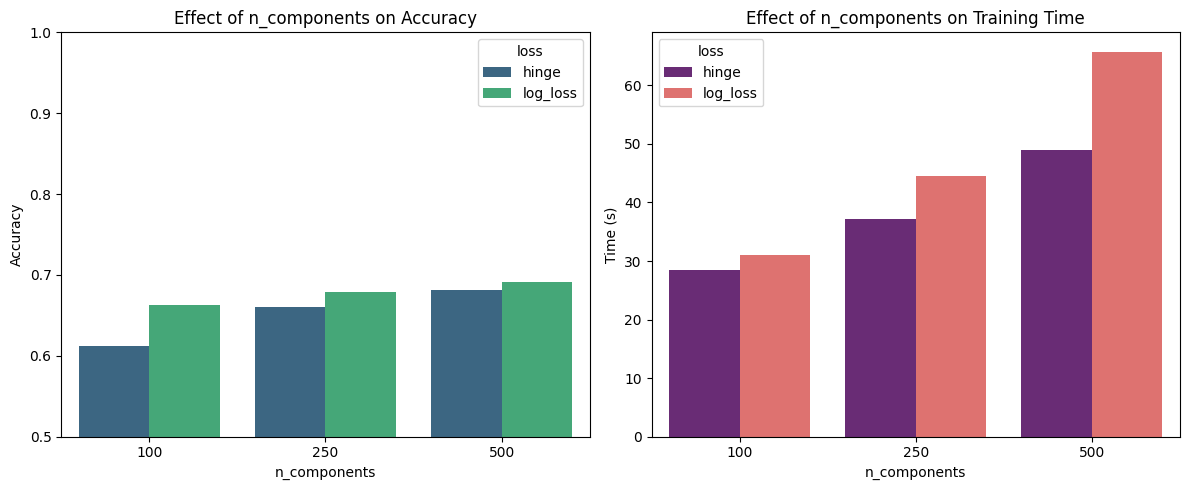


Based on this, we choose n_components=500 and loss='log_loss' for the final model.


In [14]:
# Comparative Study
components_list = [100, 250, 500]
losses = ['hinge', 'log_loss']
results = []

print("Running Comparative Study...")

for n_comp in components_list:
    for loss_name in losses:
        # Build strict pipeline for study
        pipe = Pipeline([
            ('scaler', PowerTransformer()),
            ('nystroem', Nystroem(kernel='rbf', n_components=n_comp, random_state=RANDOM_SEED)),
            ('svm', SGDClassifier(loss=loss_name, 
                                  class_weight='balanced', 
                                  random_state=RANDOM_SEED, 
                                  max_iter=500)) # Fewer iters for speed in study
        ])
        
        # Measure time and accuracy
        import time
        start_time = time.time()
        pipe.fit(X_dev_fe, y_dev)
        train_time = time.time() - start_time
        
        # Eval
        acc = pipe.score(X_dev_fe, y_dev) # Using dev set for quick check
        
        results.append({
            'n_components': n_comp,
            'loss': loss_name,
            'Accuracy': acc,
            'Time (s)': train_time
        })
        print(f"Components: {n_comp}, Loss: {loss_name} -> Acc: {acc:.4f}, Time: {train_time:.2f}s")

# Plot Results
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='n_components', y='Accuracy', hue='loss', palette='viridis')
plt.title('Effect of n_components on Accuracy')
plt.ylim(0.5, 1.0)

# Plot Time
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='n_components', y='Time (s)', hue='loss', palette='magma')
plt.title('Effect of n_components on Training Time')

plt.tight_layout()
plt.show()

print("\nBased on this, we choose n_components=500 and loss='log_loss' for the final model.")

In [15]:
# Define Pipeline
pipeline = Pipeline([
    ('scaler', PowerTransformer()),
    ('nystroem', Nystroem(kernel='rbf', n_components=500, random_state=RANDOM_SEED)),
    ('svm', SGDClassifier(loss='log_loss', 
                          class_weight='balanced', 
                          random_state=RANDOM_SEED, 
                          max_iter=1000, 
                          tol=1e-3))
])

# Define Parameter Grid
param_grid = {
    'nystroem__gamma': [0.1, 0.5, 1.0, 5.0],  # Broader range
    'svm__alpha': [0.0001, 0.001]                # Finer scale
}

# Initialize GridSearchCV with PredefinedSplit
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=ps,  # FIXED VALIDATION SET
                           scoring='f1_weighted', 
                           n_jobs=1, 
                           verbose=1)

print("Starting Grid Search for Optimized SVM...")
grid_search.fit(X_dev_fe, y_dev)

print("\nBest Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score (Validation):", grid_search.best_score_)

Starting Grid Search for Optimized SVM...
Fitting 1 folds for each of 8 candidates, totalling 8 fits

Best Parameters: {'nystroem__gamma': 0.1, 'svm__alpha': 0.0001}
Best Weighted F1 Score (Validation): 0.6803254111226863


## 4. Final Evaluation

In [16]:
# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on Test Set
y_pred = best_model.predict(X_test_fe)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Weighted F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.6699
Test Weighted F1 Score: 0.6835

Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.65      0.68     42368
           2       0.77      0.69      0.73     56661
           3       0.65      0.66      0.65      7151
           4       0.12      0.79      0.20       549
           5       0.22      0.44      0.30      1899
           6       0.33      0.51      0.40      3473
           7       0.50      0.81      0.62      4102

    accuracy                           0.67    116203
   macro avg       0.47      0.65      0.51    116203
weighted avg       0.71      0.67      0.68    116203



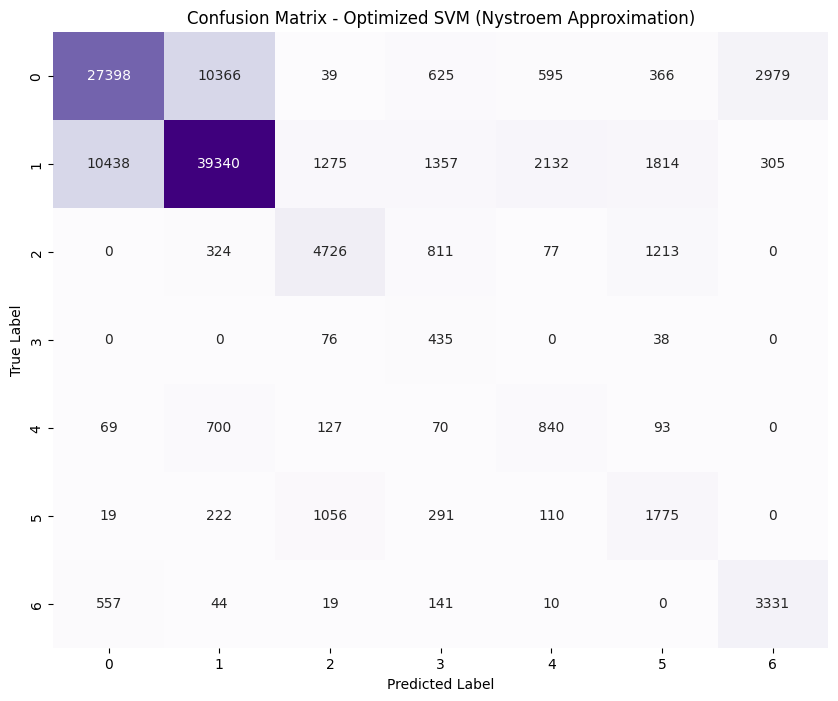

In [17]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix - Optimized SVM (Nystroem Approximation)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()